In [11]:
import pandas as pd

data = """Time_h,Biomass_gL,Glucose_gL
0,0.2,50
2,0.6,44
4,1.5,38
6,2.7,31
8,3.8,24
10,4.5,18
12,4.8,13
14,4.9,9
16,5.0,6
18,5.0,4
"""

with open("fermentation_data.csv", "w") as f:
    f.write(data)

df = pd.read_csv("fermentation_data.csv")
df.head()


,Time_h,Biomass_gL,Glucose_gL
0,0,0.2,50
1,2,0.6,44
2,4,1.5,38
3,6,2.7,31
4,8,3.8,24


In [12]:
print("Veri Özeti:")
print(df.describe())

print("\nEksik veri var mı?")
print(df.isnull().sum())


Veri Özeti:
          Time_h  Biomass_gL  Glucose_gL
count  10.000000   10.000000   10.000000
mean    9.000000    3.300000   23.700000
std     6.055301    1.908461   16.418486
min     0.000000    0.200000    4.000000
25%     4.500000    1.800000   10.000000
50%     9.000000    4.150000   21.000000
75%    13.500000    4.875000   36.250000
max    18.000000    5.000000   50.000000

Eksik veri var mı?
Time_h        0
Biomass_gL    0
Glucose_gL    0
dtype: int64


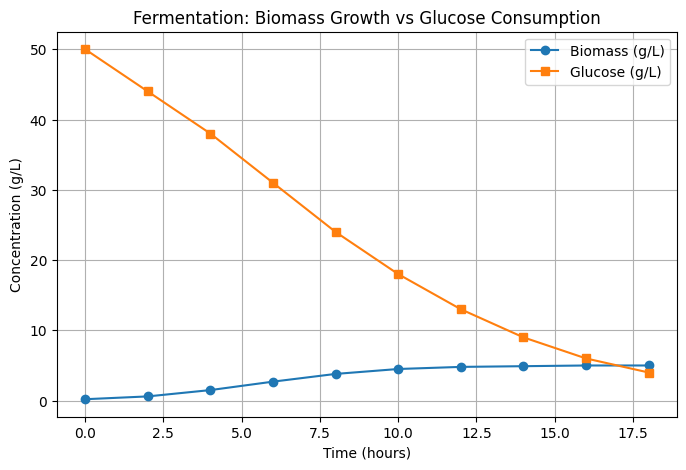

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df["Time_h"], df["Biomass_gL"], marker='o', label="Biomass (g/L)")
plt.plot(df["Time_h"], df["Glucose_gL"], marker='s', label="Glucose (g/L)")
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (g/L)")
plt.title("Fermentation: Biomass Growth vs Glucose Consumption")
plt.legend()
plt.grid(True)
plt.show()


### 🔍 Data Analysis – Biomass Growth vs Glucose Consumption

The plot clearly shows two opposing trends:  
- **Biomass (cell mass)** increases rapidly during the first 8–10 hours, indicating active microbial growth.  
- **Glucose concentration** decreases steadily, meaning it is being consumed as the main carbon source.

Between hours 8 and 12, the **growth rate slows down**, suggesting that the system is reaching the end of the exponential phase and entering the stationary phase.  
At around 14–16 hours, the glucose concentration becomes very low (~6 g/L), meaning that the process is close to substrate limitation.

➡️ This pattern is typical for **batch fermentation**:  
the substrate is consumed over time until it becomes the limiting factor for biomass production.


In [14]:
import numpy as np
import pandas as pd

def rolling_linreg(x, y, window=4):
    """
    x ve y üzerinde kayan pencere ile (basit) lineer regresyon yapar.
    Her pencere için slope, intercept ve R^2 döndürür.
    Sonuçlar pencerenin orta noktasına hizalanır.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)
    w = window
    centers = []
    slopes = []
    intercepts = []
    r2s = []

    for i in range(0, n - w + 1):
        xi = x[i:i+w]
        yi = y[i:i+w]
        # lineer fit
        A = np.vstack([xi, np.ones_like(xi)]).T
        m, b = np.linalg.lstsq(A, yi, rcond=None)[0]
        yhat = m*xi + b
        ss_res = np.sum((yi - yhat)**2)
        ss_tot = np.sum((yi - np.mean(yi))**2)
        r2 = 1 - ss_res/ss_tot if ss_tot > 0 else 0.0

        center = np.mean(xi)
        centers.append(center)
        slopes.append(m)
        intercepts.append(b)
        r2s.append(r2)

    return np.array(centers), np.array(slopes), np.array(intercepts), np.array(r2s)


>>> Phase Detection Summary
mu_max (1/h): 0.436
Exponential phase ~ from t ≈ 3.0 h to 7.0 h
Stationary candidate ~ starts around t ≈ 15.0 h
Substrate limitation hint: glucose crossed threshold at t ≈ 14.0 h (S ≤ 12.5 g/L)


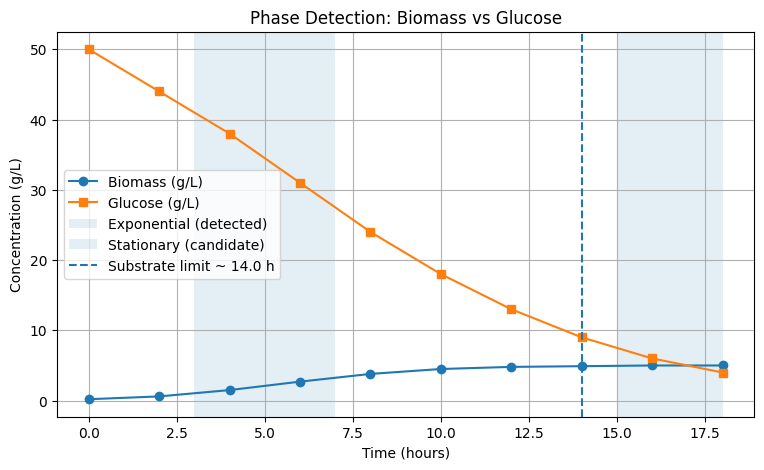

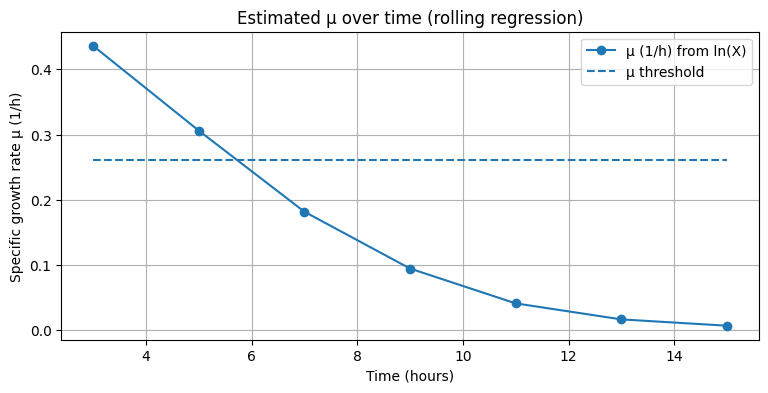

In [15]:
import matplotlib.pyplot as plt

# Veriyi alalım
t = df["Time_h"].values.astype(float)
X = df["Biomass_gL"].values.astype(float)
S = df["Glucose_gL"].values.astype(float)

# Sayısal kararlılık için çok küçük biyokütle değerlerini düzeltelim (log alacağız)
eps = 1e-6
X_safe = np.clip(X, eps, None)
lnX = np.log(X_safe)

# --- 2.1: ln(X) üzerinde kayan pencereli regresyon -> slope = µ (spesifik büyüme hızı) ---
centers, mu_slope, _, mu_r2 = rolling_linreg(t, lnX, window=4)

# µ_max ve eşiğe göre "exponential band" seçimi
mu_max = np.nanmax(mu_slope)
mu_thresh = 0.60 * mu_max        # default: en iyi büyümenin %60'ı ve üstü
r2_thresh = 0.95                 # fit kalitesi eşiği

exp_mask = (mu_slope >= mu_thresh) & (mu_r2 >= r2_thresh)

# ardışık doğru dilimini "exponential phase" olarak alalım (ilk/uzun bandı seçiyoruz)
def longest_true_run(mask, xs):
    """True/False dizisindeki en uzun True bloğunun başlangıç-bitiş indekslerini döndürür."""
    best_start = best_end = -1
    curr_start = None
    best_len = 0
    for i, val in enumerate(mask):
        if val and curr_start is None:
            curr_start = i
        if (not val or i == len(mask)-1) and curr_start is not None:
            end_i = i if not val else i  # kapanış noktası
            run_len = end_i - curr_start + (1 if val and i == len(mask)-1 else 0)
            if run_len > best_len:
                best_len = run_len
                best_start, best_end = curr_start, end_i
            curr_start = None
    return best_start, best_end

exp_i0, exp_i1 = longest_true_run(exp_mask, centers)

if exp_i0 != -1:
    exp_t_start = centers[exp_i0]
    exp_t_end   = centers[exp_i1]
else:
    exp_t_start = exp_t_end = None

# --- 2.2: dX/dt ile "stationary" (büyüme ~0) bölgesi ipucu ---
# X üzerinde yine kayan regresyon (slope ~ dX/dt)
_, dXdt, _, dXdt_r2 = rolling_linreg(t, X, window=4)
# Eşik: maksimum dX/dt'nin %10'undan küçükse "yaklaşık sabit"
dXdt_max = np.nanmax(dXdt)
dx_thresh = 0.10 * dXdt_max if dXdt_max > 0 else 0.0
stat_mask = (dXdt <= dx_thresh)

# exponential bitişinden sonra ilk uzun sabit bandı "stationary" diye işaretleyelim
stat_i0, stat_i1 = longest_true_run(stat_mask, centers)
if stat_i0 != -1:
    stat_t_start = centers[stat_i0]
    stat_t_end   = centers[stat_i1]
else:
    stat_t_start = stat_t_end = None

# --- 2.3: Substrate limitation ipucu (glikoz eşiği) ---
# Literatürdeki kritik glikoz eşiği süreçten sürece değişir; burada örnek bir heuristik:
# "başlangıç glikozunun %20-25'in altına düşmesi" veya "S <= 10 g/L"
S0 = S[0]
S_lim_abs = 10.0
S_lim_rel = 0.25 * S0
S_threshold = max(S_lim_abs, S_lim_rel)  # daha temkinli eşik
# eşik altına ilk iniş zamanı:
below = np.where(S <= S_threshold)[0]
t_S_lim = t[below[0]] if len(below) > 0 else None

# --- 2.4: Özet yazdır ---
print(">>> Phase Detection Summary")
print(f"mu_max (1/h): {mu_max:.3f}")
if exp_t_start is not None:
    print(f"Exponential phase ~ from t ≈ {exp_t_start:.1f} h to {exp_t_end:.1f} h")
else:
    print("Exponential phase: net bir bant bulunamadı (eşikleri gevşetmeyi deneyin).")

if stat_t_start is not None:
    print(f"Stationary candidate ~ starts around t ≈ {stat_t_start:.1f} h")
else:
    print("Stationary: net bir bant bulunamadı (eşikleri kontrol edin).")

if t_S_lim is not None:
    print(f"Substrate limitation hint: glucose crossed threshold at t ≈ {t_S_lim:.1f} h (S ≤ {S_threshold:.1f} g/L)")
else:
    print("Substrate limitation hint: glucose threshold not crossed under current rule.")

# --- 2.5: Görselleştirme (faz sınırlarını grafikte göster) ---
plt.figure(figsize=(9,5))
plt.plot(t, X, marker='o', label="Biomass (g/L)")
plt.plot(t, S, marker='s', label="Glucose (g/L)")
if exp_t_start is not None:
    plt.axvspan(exp_t_start, exp_t_end, alpha=0.12, label="Exponential (detected)")
if stat_t_start is not None:
    plt.axvspan(stat_t_start, t[-1], alpha=0.12, label="Stationary (candidate)")
if t_S_lim is not None:
    plt.axvline(t_S_lim, linestyle='--', label=f"Substrate limit ~ {t_S_lim:.1f} h")
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (g/L)")
plt.title("Phase Detection: Biomass vs Glucose")
plt.legend()
plt.grid(True)
plt.show()

# --- 2.6: µ(t) eğrisi ---
plt.figure(figsize=(9,4))
plt.plot(centers, mu_slope, marker='o', label="µ (1/h) from ln(X)")
plt.hlines(mu_thresh, centers.min(), centers.max(), linestyles='--', label="µ threshold")
plt.xlabel("Time (hours)")
plt.ylabel("Specific growth rate µ (1/h)")
plt.title("Estimated µ over time (rolling regression)")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
mu_report = f"""
 📌 Phase Detection Report

- µ_max (1/h): {mu_max:.3f}
- Exponential phase: {'t ≈ %.1f–%.1f h' % (exp_t_start, exp_t_end) if exp_t_start is not None else 'not detected (adjust thresholds)'}
- Stationary (candidate): {'starts ~ t ≈ %.1f h' % stat_t_start if stat_t_start is not None else 'not detected'}
- Substrate limitation hint: {'t ≈ %.1f h (S ≤ %.1f g/L)' % (t_S_lim, S_threshold) if t_S_lim is not None else 'threshold not crossed'}

Notes: Thresholds are heuristic; adjust `mu_thresh`, `r2_thresh`, window size and glucose threshold to match your process.
"""
print(mu_report)



 📌 Phase Detection Report

- µ_max (1/h): 0.436
- Exponential phase: t ≈ 3.0–7.0 h
- Stationary (candidate): starts ~ t ≈ 15.0 h
- Substrate limitation hint: t ≈ 14.0 h (S ≤ 12.5 g/L)

Notes: Thresholds are heuristic; adjust `mu_thresh`, `r2_thresh`, window size and glucose threshold to match your process.

